In [1]:
#Libraries Required
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.preprocessing as preprocessing
import statsmodels as sm
import sklearn.linear_model as linear_model
import sklearn.cross_validation as cross_validation
import sklearn.metrics as metrics
import sklearn.tree as tree


/Users/yawenhan/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Load data
data= pd.read_csv("/Users/yawenhan/Documents/Spring2018/DataMining/Final Project/mushrooms.csv")
df= pd.DataFrame(data)
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


## Preliminary Data Analysis

In [3]:
#Basic dataset info
print(data.shape)

(8124, 23)


Let’s plot the distribution of each feature, so that we have a better understanding what we have in our data. We draw the number of values for each category feature.

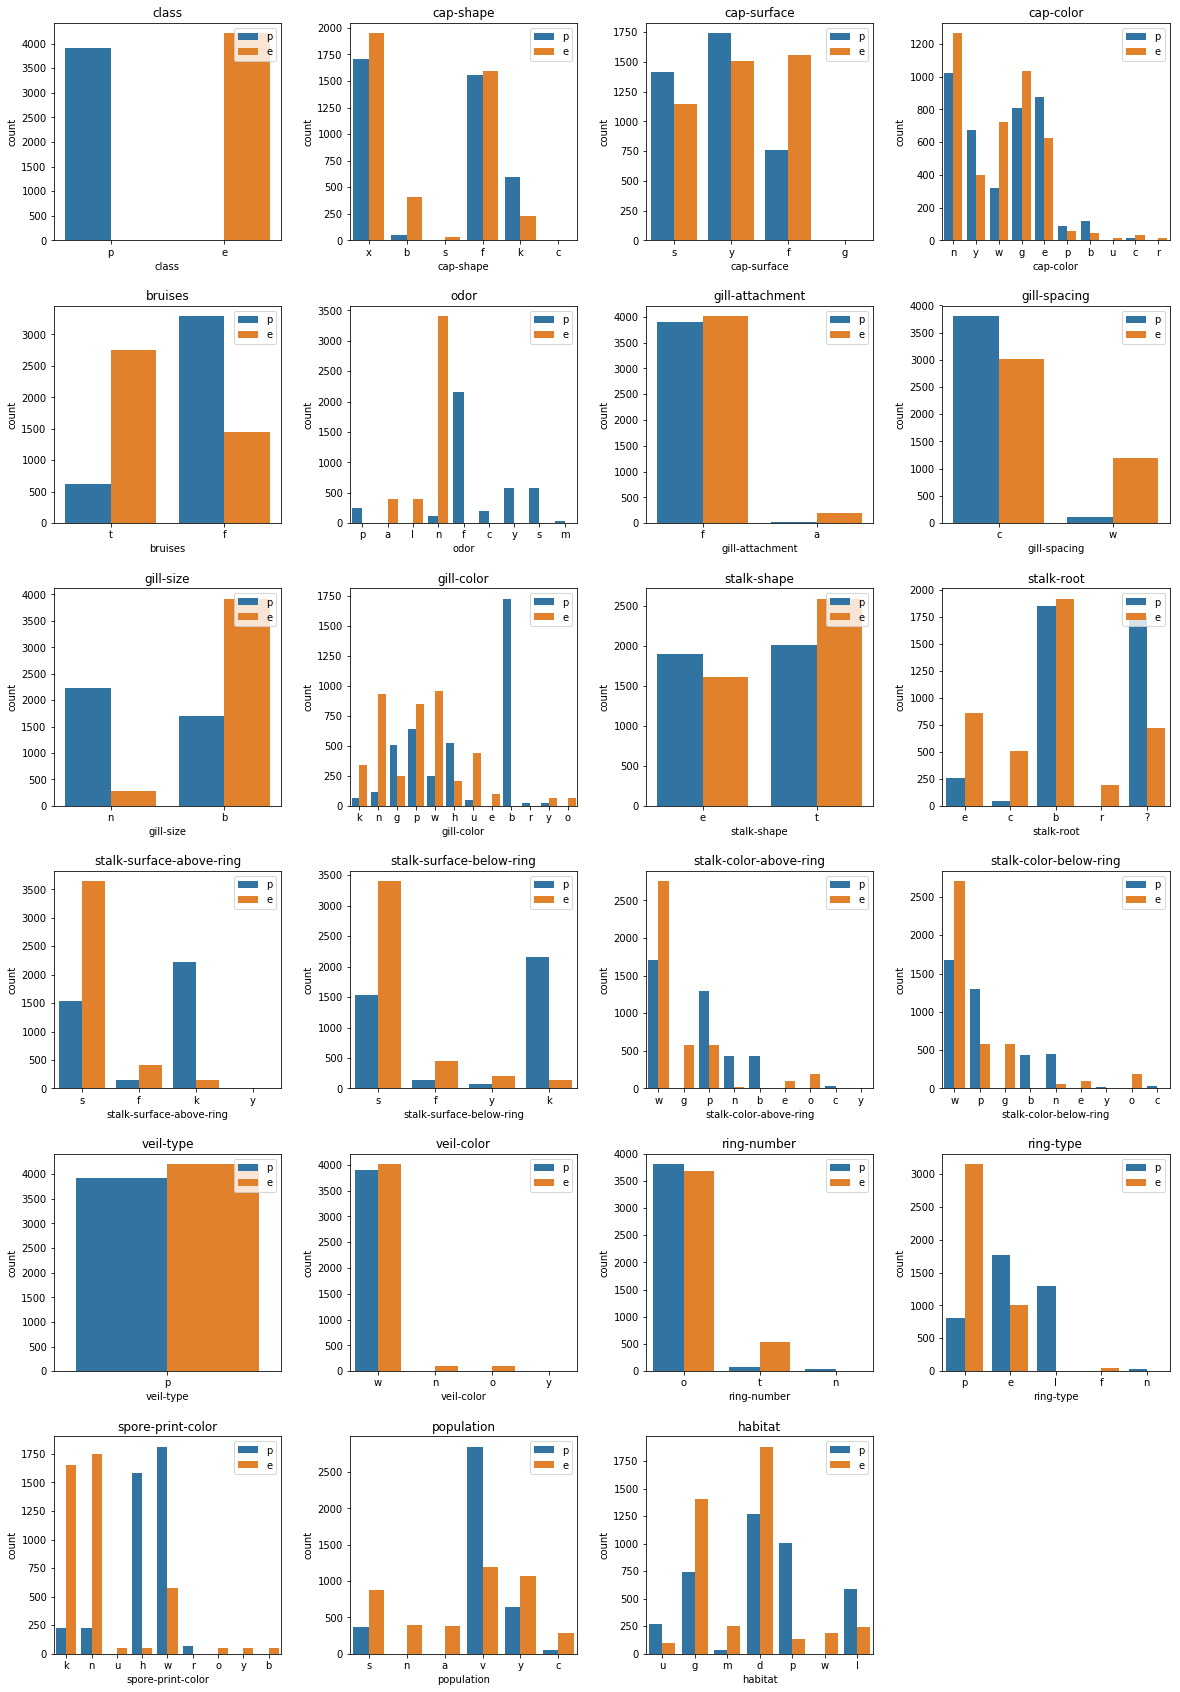

In [4]:
#Histogram for all attributes
fig = plt.figure(figsize=(20,30))
cols = 4
rows = 6
for i, column in enumerate(data.columns):   
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(column)     
    sns.countplot(data[column],hue=data['class'],axes=ax)
    plt.legend(loc='upper right')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
display(fig)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
class                       8124 non-null object
cap-shape                   8124 non-null object
cap-surface                 8124 non-null object
cap-color                   8124 non-null object
bruises                     8124 non-null object
odor                        8124 non-null object
gill-attachment             8124 non-null object
gill-spacing                8124 non-null object
gill-size                   8124 non-null object
gill-color                  8124 non-null object
stalk-shape                 8124 non-null object
stalk-root                  8124 non-null object
stalk-surface-above-ring    8124 non-null object
stalk-surface-below-ring    8124 non-null object
stalk-color-above-ring      8124 non-null object
stalk-color-below-ring      8124 non-null object
veil-type                   8124 non-null object
veil-color                  8124 non-null object
ring-number

In [6]:
#Missing value info
def cc(x):
    return sum(x=='?')
ms=data.apply(cc)
ms=pd.DataFrame(ms)
#ms=ms.transpose()
ms.columns=['Total missing value']
ms

,Total missing value
class,0
cap-shape,0
cap-surface,0
cap-color,0
bruises,0
odor,0
gill-attachment,0
gill-spacing,0
gill-size,0
gill-color,0


## Missing Value

In [7]:
#Replace the missing value of "stalk-root" with the mode
data.loc[data['stalk-root']=='?','stalk-root'] = 'b'

In [8]:
#Ckeck if there is still any missing value in the dataset
ms=data.apply(cc)
ms=pd.DataFrame(ms)
#ms=ms.transpose()
ms.columns=['Total missing value']
ms

,Total missing value
class,0
cap-shape,0
cap-surface,0
cap-color,0
bruises,0
odor,0
gill-attachment,0
gill-spacing,0
gill-size,0
gill-color,0


## "ring-number" Feature Simplification

In [9]:
#Make Country attribute easier to analysis
data.loc[data['ring-number']=='n','ring-number'] = 0
data.loc[data['ring-number']=='o','ring-number'] = 1
data.loc[data['ring-number']=='t','ring-number'] = 2

In [10]:
data['ring-number'].describe()

count     8124
unique       3
top          1
freq      7488
Name: ring-number, dtype: int64

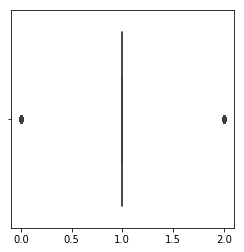

In [11]:
num=data['ring-number'].tolist()
fig_num = plt.figure(figsize=(4,4))
sns.boxplot(num)
display(fig_num)

## Drop 'veil-type'

In [12]:
del data["veil-type"]

## Feature Selection

The chi-square test is a statistical test of independence to determine the dependency of two variables. It shares similarities with coefficient of determination, R². However, chi-square test is only applicable to categorical or nominal data while R² is only applicable to numeric data.

From the definition, of chi-square we can easily deduce the application of chi-square technique in feature selection. Suppose you have a target variable (i.e., the class label) and some other features (feature variables) that describes each sample of the data. Now, we calculate chi-square statistics between every feature variable and the target variable and observe the existence of a relationship between the variables and the target. If the target variable is independent of the feature variable, we can discard that feature variable. If they are dependent, the feature variable is very important.

Check chi2 significance of 22 features.

In [13]:
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
numeric_data = pd.DataFrame()
feature_columns = data.columns[1:]
for f in feature_columns:
    numeric_data[f] = le.fit_transform(data[f])
    
chi_statics, p_values = chi2(numeric_data, data['class'])

chi2_result = pd.DataFrame({'features': feature_columns, 'chi2_statics': chi_statics, 'p_values': p_values})
chi2_result.dropna(axis=0, how='any', inplace=True)

chi2_result=chi2_result.sort_values(by='chi2_statics', ascending=False)[['features', 'chi2_statics', 'p_values']].reset_index().drop('index', axis=1)

chi2_result


,features,chi2_statics,p_values
0,gill-color,5957.764469,0.000000e+00
1,ring-type,1950.610146,0.000000e+00
2,gill-size,1636.606833,0.000000e+00
3,stalk-root,1358.358638,2.351166e-297
4,bruises,1194.277352,1.069037e-261
5,gill-spacing,826.795274,8.061293e-182
6,habitat,751.309489,2.082916e-165
7,spore-print-color,379.132729,1.922119e-84
8,population,311.766736,9.002366e-70
9,stalk-surface-above-ring,222.982400,2.022392e-50


In [14]:
#chi2_result_fig=chi2_result.sort_values(by='chi2_statics', ascending=True)[['features', 'chi2_statics']].set_index('features')['chi2_statics']
chi2_result = chi2_result.sort_values(by='chi2_statics',ascending=True)
chi2_result

,features,chi2_statics,p_values
20,gill-attachment,3.505447,6.116734e-02
19,veil-color,5.126826,2.355878e-02
18,cap-color,11.511382,6.917135e-04
17,cap-shape,17.508364,2.860465e-05
16,ring-number,25.646335,4.100735e-07
15,stalk-shape,36.594105,1.454709e-09
14,odor,75.910163,2.968682e-18
13,stalk-color-below-ring,109.789410,1.089740e-25
12,stalk-color-above-ring,119.792216,7.024638e-28
11,stalk-surface-below-ring,206.648180,7.398869e-47


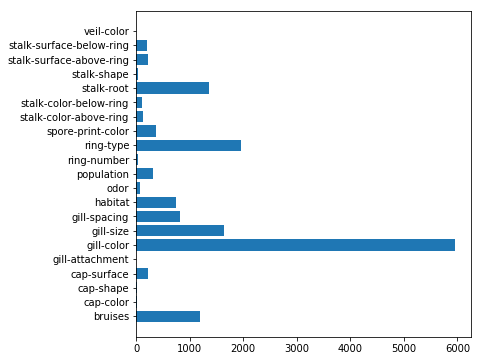

In [15]:
fig2 = plt.figure(figsize = (6,6))
plt.barh(chi2_result['features'],chi2_result['chi2_statics'])
display(fig2)

In [16]:
use_features = chi2_result.sort_values(by='chi2_statics', ascending=False)['features'].head(7).values

print('top 7 most useful features are:')
for f in use_features:
    print(f)

top 7 most useful features are:
gill-color
ring-type
gill-size
stalk-root
bruises
gill-spacing
habitat


## Catrgorical Features Discretization

We can see that the dataset has values in strings.We need to convert all the unique values to integers. Thus we perform label encoding on the data.

from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
for col in data.columns:
    data[col] = labelencoder.fit_transform(data[col]) 
data.head()

For features with two values I will use LabelBinarizer, otherwise I will use pd.get_dummies.

In [17]:
data_reduced = pd.DataFrame()
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
    
for f in use_features:
    if len(data[f].unique()) == 2:
        data_reduced[f] = lb.fit_transform(data[f])
    else:
        dummies = data[f].str.get_dummies()
        dummies.columns = ['{}_{}'.format(f, v) for v in dummies.columns]
        data_reduced = pd.concat([data_reduced, dummies], axis=1)

In [18]:

data_reduced['class'] = lb.fit_transform(data['class'])

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
for feature in data.columns:
    if len(data[feature].unique()) == 2:
        data[feature] = lb.fit_transform(data[feature])
data.head(5)

features_onehot = []
for feature in data.columns[1:]:
    if len(data[feature].unique()) > 2:
        features_onehot.append(feature)
temp = pd.get_dummies(data[features_onehot])
data = data.join(temp)
data = data.drop(features_onehot, axis=1)
data[:3]

In [19]:
data_reduced.head(5)

,gill-color_b,gill-color_e,gill-color_g,gill-color_h,gill-color_k,gill-color_n,gill-color_o,gill-color_p,gill-color_r,gill-color_u,...,bruises,gill-spacing,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,class
0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
1,0,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
4,0,0,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0


In [20]:
print(data_reduced.shape)

(8124, 32)


## Correlation among Features

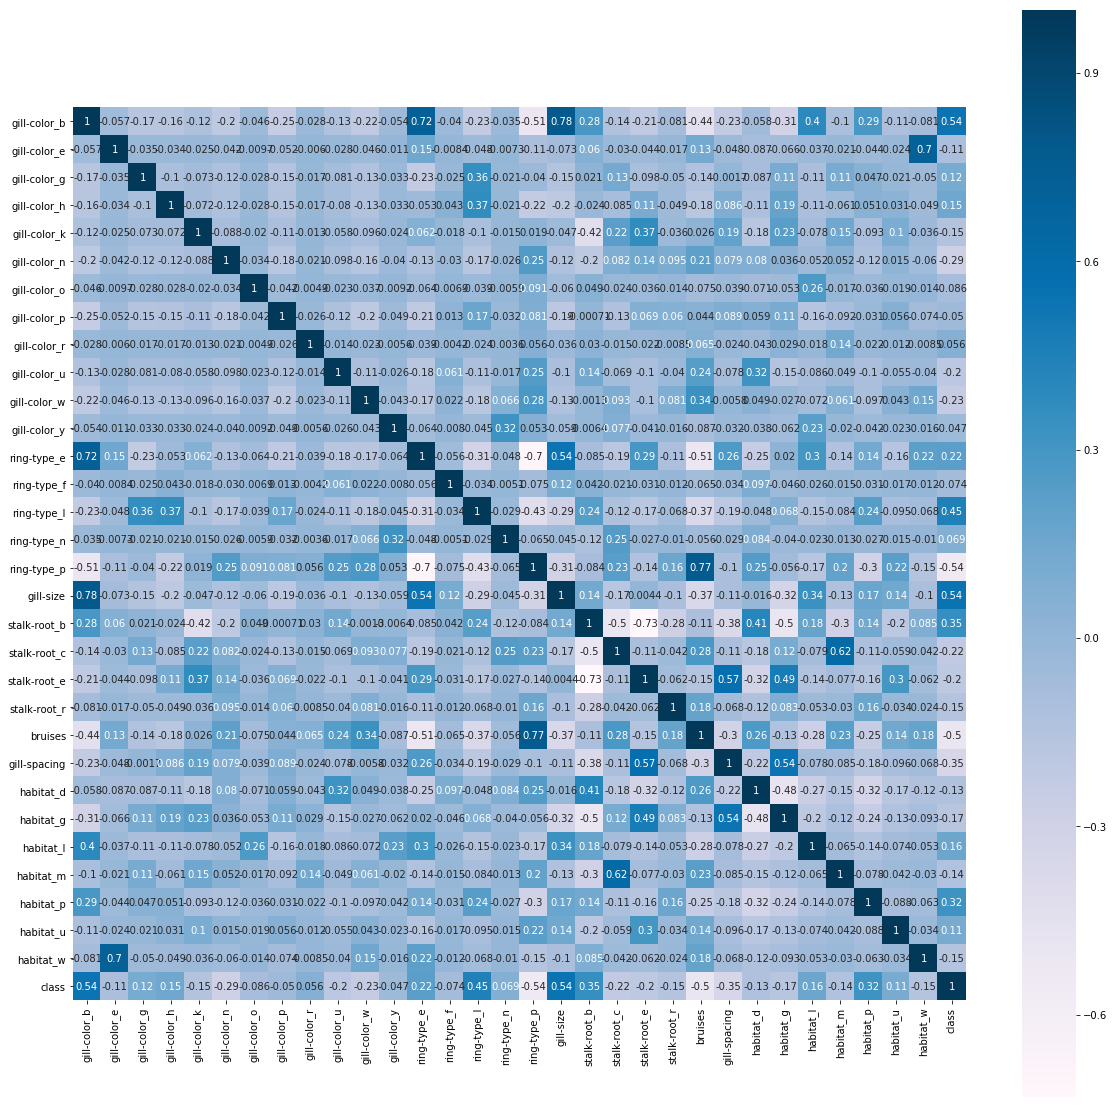

In [21]:
#Correlation and heatmap
hmap = data_reduced.corr()
fig3 = plt.figure(figsize = (20,20))
sns.heatmap(hmap,vmax=1,annot=True,cmap="PuBu", square=True)
display(fig3)

## Separating features and label

In [22]:
X = data_reduced.iloc[:,0:30]  # all rows, all the features and no labels
y = data_reduced.iloc[:,31]  # all rows, label only

In [23]:
X_noPCA = pd.DataFrame(X)
#X_noPCA.to_csv("/Users/yawenhan/Documents/Spring2018/DataMining/Final Project/mushrooms_transformed_noPCA.csv")
X_noPCA.head(5)

,gill-color_b,gill-color_e,gill-color_g,gill-color_h,gill-color_k,gill-color_n,gill-color_o,gill-color_p,gill-color_r,gill-color_u,...,stalk-root_e,stalk-root_r,bruises,gill-spacing,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u
0,0,0,0,0,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,0,0,0,0,0,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
4,0,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0


## Principal Component Analysis

In [24]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(X)

array([[ -4.41721007e-01,   4.99930275e-01,  -1.01993437e+00, ...,
          7.60846220e-14,  -2.47305573e-15,  -4.26325324e-15],
       [ -8.87748056e-01,   9.42505013e-01,  -4.87901455e-01, ...,
         -1.53250270e-14,  -5.06461369e-15,  -1.73674089e-15],
       [ -1.01176648e+00,   4.04396398e-01,  -6.60589092e-01, ...,
          1.51004958e-14,   3.63273292e-14,  -2.09050944e-15],
       ..., 
       [ -2.67072046e-01,  -1.01431503e-01,  -6.01975517e-02, ...,
          8.43723959e-17,  -6.35735688e-18,  -1.57848071e-17],
       [  1.44628093e+00,  -5.06075188e-01,  -4.64608221e-01, ...,
          7.47979369e-18,   5.69675632e-18,  -1.09138098e-17],
       [ -1.76633517e-01,  -1.51290104e-01,   7.76065792e-02, ...,
          2.53839678e-17,   5.83175997e-18,  -5.59546469e-18]])

In [25]:
explained_variance=pca.explained_variance_
ratio=explained_variance/explained_variance.sum()*100
ratio_table=pd.DataFrame(ratio)

ratio_table=ratio_table.transpose()
ratio_table.index=['Variance Ratio']
ratio_table

array([  2.52328176e+01,   1.74776572e+01,   1.14496987e+01,
         7.11418889e+00,   5.14285367e+00,   4.63287200e+00,
         4.10819187e+00,   3.50199616e+00,   3.38968528e+00,
         3.01876257e+00,   2.69671407e+00,   2.45027311e+00,
         2.03544876e+00,   1.55518821e+00,   1.28384391e+00,
         1.09848643e+00,   9.13704702e-01,   6.61136491e-01,
         5.85471153e-01,   4.91520541e-01,   3.02312702e-01,
         2.73639153e-01,   1.90218855e-01,   1.60940668e-01,
         1.11759846e-01,   9.13160428e-02,   2.93013311e-02,
         4.23551544e-29,   1.64170672e-29,   2.32458649e-30])

In [26]:
covariance=pca.get_covariance()
#covariance

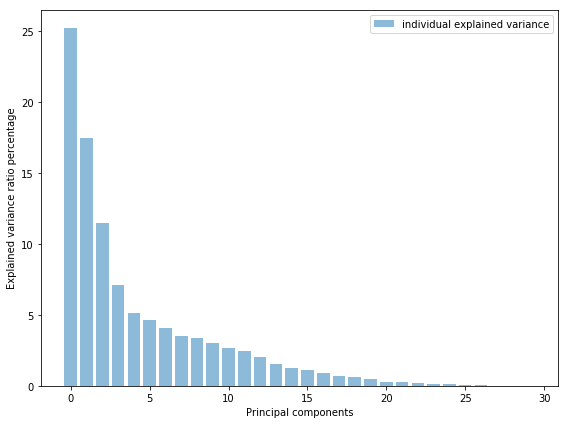

In [27]:
#with plt.style.context('dark_background'):
fig4=plt.figure(figsize=(8, 6))

plt.bar(range(30), ratio, alpha=0.5, align='center',label='individual explained variance')
plt.ylabel('Explained variance ratio percentage')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
display(fig4)

In [28]:
pca_modified=PCA(n_components=16)
X_original=X.copy()
X=pca_modified.fit_transform(X)

## Export Dataset X_df to csv file

In [29]:
X_df = pd.DataFrame(X)
#X_df.to_csv("/Users/yawenhan/Documents/Spring2018/DataMining/Final Project/mushrooms_transformed.csv")


In [30]:
X_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.441721,0.499930,-1.019934,0.364819,0.524723,-0.586039,-0.184138,0.861595,0.567298,0.781090,-0.273801,-0.121966,-0.493980,-0.137461,0.656942,0.038821
1,-0.887748,0.942505,-0.487901,0.638073,-0.022219,-0.193269,-0.006155,0.393103,-0.724111,-0.134894,-0.374415,0.120674,0.347641,-0.389202,0.628934,0.151027
2,-1.011766,0.404396,-0.660589,0.783062,-0.111616,-0.937524,0.034958,-0.135032,-0.516939,-0.064187,0.554900,-0.066051,0.552097,0.225098,-0.062884,-0.481237
3,-0.531835,0.440898,-1.083445,0.286319,0.383954,-1.026029,0.086414,0.194540,0.800578,0.657328,0.158808,0.343583,-0.536511,0.115420,-0.082955,-0.301071
4,0.685056,1.736544,-0.348072,-0.528561,-0.242708,-0.002123,-0.283552,0.138374,-0.076642,-0.055074,-0.060635,-0.428437,-0.131020,-0.330147,0.598197,0.191826


## Model Development

### Splitting the data into training and testing dataset

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_df,y,test_size=0.2,random_state=4)

### 1) Logistic Regression

In [32]:
cls = linear_model.LogisticRegression()

cls_result=cls.fit(X_train, y_train)
cls_pred = cls.predict(X_test)
cm = metrics.confusion_matrix(y_test, cls_pred)

cls_fig=plt.figure(figsize=(18,6))
cls_cm = cls_fig.add_subplot(1, 2, 1)
cls_cm=sns.heatmap(cm, cmap="GnBu",annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")
plt.title('Logistic Regression Confusion Matrix')
print("The accuracy of the logistic regression on test set is %f" % metrics.accuracy_score(cls_pred,y_test))
print ("The F-measure score of the logistic regression on test set is %f" % skl.metrics.f1_score(cls_pred,y_test))
coefs = pd.Series(cls.coef_[0])
#index=X_train.columns


The accuracy of the logistic regression on test set is 0.963077
The F-measure score of the logistic regression on test set is 0.961440


In [33]:
from sklearn.metrics import classification_report
# Check metrics on testing set.
print('\nTesting Classification Report:')
print(classification_report(y_test, cls_pred))



Testing Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.97      0.96       845
          1       0.96      0.96      0.96       780

avg / total       0.96      0.96      0.96      1625



In [34]:
coefs=pd.DataFrame(coefs)
coefs=coefs.transpose()
coefs.index=['Coef']
coefs

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Coef,2.66359,-3.000724,2.84815,3.124705,1.112909,-0.119206,1.424263,3.219751,0.344316,1.318465,-2.563811,6.534658,0.322832,0.848229,1.547585,-4.35026


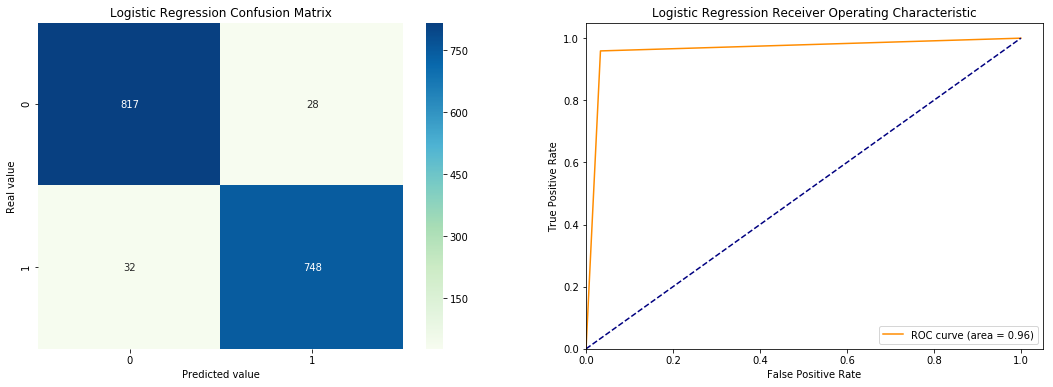

In [35]:
# calculate the fpr and tpr for all thresholds of the classification
cls_roc = cls_fig.add_subplot(1, 2, 2)
fpr, tpr, threshold = metrics.roc_curve(y_test, cls_pred)
roc_auc = metrics.auc(fpr, tpr)

cls_roc=plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)'% roc_auc)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Receiver Operating Characteristic')
plt.legend(loc="lower right")
display(cls_fig)

In [36]:
cls.set_params(penalty='l1',C=0.1)
cls.fit(X_train, y_train)
cls_pred=cls.predict(X_test)
print("The accuracy of the logistic regression on test set is %f" % metrics.accuracy_score(cls_pred,y_test))
print ("The F-measure score of the logistic regression on test set is %f" % skl.metrics.f1_score(cls_pred,y_test))
#coefs = pd.Series(cls.coef_[0])
fpr, tpr, threshold = metrics.roc_curve(y_test, cls_pred)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)


The accuracy of the logistic regression on test set is 0.963077
The F-measure score of the logistic regression on test set is 0.961440
0.96291913215


### 2) Decision Tree

In [37]:
from sklearn import model_selection
kfold = model_selection.KFold(n_splits=10, random_state=7)
scoring = 'accuracy'

dtc = tree.DecisionTreeClassifier()
dtc.fit(X_train, y_train)
dtc_pred=dtc.predict(X_test)
cm = metrics.confusion_matrix(y_test, dtc_pred)

dtc_fig=plt.figure(figsize=(18,6))
dtc_cm = dtc_fig.add_subplot(1, 2, 1)

dtc_cm=sns.heatmap(cm, cmap="GnBu",annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")
plt.title('Decision Tree Confusion Matrix')
print("The accuracy of the decision tree is %f" % metrics.accuracy_score(dtc_pred,y_test))
print ("The F-measure score of the decision tree is %f" % skl.metrics.f1_score(dtc_pred,y_test))

dtc_results = model_selection.cross_val_score(dtc, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %f" % (dtc_results.mean()))

The accuracy of the decision tree is 1.000000
The F-measure score of the decision tree is 1.000000
10-fold cross validation average accuracy: 1.000000


In [38]:
print('\nTesting Classification Report:')
print(classification_report(y_test, dtc_pred))


Testing Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       845
          1       1.00      1.00      1.00       780

avg / total       1.00      1.00      1.00      1625



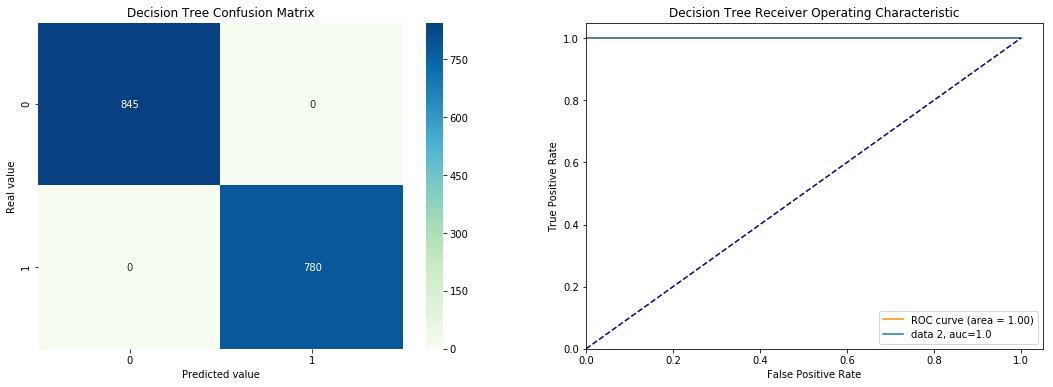

In [39]:
# calculate the fpr and tpr for all thresholds of the classification
dtc_roc = dtc_fig.add_subplot(1, 2, 2)
fpr, tpr, threshold = metrics.roc_curve(y_test, dtc_pred)
roc_auc = metrics.auc(fpr, tpr)

dtc_roc=plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)'% roc_auc)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Receiver Operating Characteristic')
plt.legend(loc="lower right")
display(dtc_fig)

In [40]:
#import graphviz 
dot_data = tree.export_graphviz(dtc, out_file=None) 
                               # feature_names=iris.feature_names,class_names=iris.target_names,filled=True,rounded=True,special_characters=True)  
#graph = graphviz.Source(dot_data)  
print(dot_data)


digraph Tree {
node [shape=box] ;
0 [label="X[0] <= -0.912\ngini = 0.499\nsamples = 6499\nvalue = [3363, 3136]"] ;
1 [label="X[5] <= 0.609\ngini = 0.009\nsamples = 1799\nvalue = [1791, 8]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.0\nsamples = 1791\nvalue = [1791, 0]"] ;
1 -> 2 ;
3 [label="gini = 0.0\nsamples = 8\nvalue = [0, 8]"] ;
1 -> 3 ;
4 [label="X[1] <= 0.592\ngini = 0.445\nsamples = 4700\nvalue = [1572, 3128]"] ;
0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
5 [label="X[7] <= -0.367\ngini = 0.28\nsamples = 3638\nvalue = [613, 3025]"] ;
4 -> 5 ;
6 [label="gini = 0.0\nsamples = 240\nvalue = [240, 0]"] ;
5 -> 6 ;
7 [label="X[15] <= 0.326\ngini = 0.195\nsamples = 3398\nvalue = [373, 3025]"] ;
5 -> 7 ;
8 [label="X[8] <= 0.662\ngini = 0.131\nsamples = 3255\nvalue = [230, 3025]"] ;
7 -> 8 ;
9 [label="X[5] <= 0.97\ngini = 0.072\nsamples = 3032\nvalue = [113, 2919]"] ;
8 -> 9 ;
10 [label="X[3] <= -0.652\ngini = 0.047\nsamples = 

In [41]:
dtc.get_params(deep=True)

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

In [42]:
dtc.set_params(criterion='entropy',splitter='random',max_features='log2')
dtc.fit(X_train, y_train)
dtc_pred=dtc.predict(X_test)
print('\nTesting Classification Report:')
print(classification_report(y_test, dtc_pred))


Testing Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       845
          1       1.00      1.00      1.00       780

avg / total       1.00      1.00      1.00      1625



### 3) Artificial Neural Network

Class MLPClassifier implements a multi-layer perceptron (MLP) algorithm that trains using Backpropagation.

The default solver ‘adam’ works pretty well on relatively large datasets (with thousands of training samples or more) in terms of both training time and validation score. 

In [43]:
from sklearn.neural_network import MLPClassifier
ann= MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
ann.fit(X_train, y_train)  
ann_pred=ann.predict(X_test)
cm = metrics.confusion_matrix(y_test, ann_pred)

ann_fig=plt.figure(figsize=(18,6))
ann_cm = ann_fig.add_subplot(1, 2, 1)

ann_cm=sns.heatmap(cm, cmap="GnBu",annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")
plt.title('Artificial Neural Network Confusion Matrix')
print("The accuracy of the artificial neural network is %f" % metrics.accuracy_score(ann_pred,y_test))
print ("The F-measure score of the artificial neural network is %f" % skl.metrics.f1_score(ann_pred,y_test))

ann_results = model_selection.cross_val_score(ann, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %f" % (ann_results.mean()))

The accuracy of the artificial neural network is 1.000000
The F-measure score of the artificial neural network is 1.000000
10-fold cross validation average accuracy: 1.000000


In [44]:
print('\nTesting Classification Report:')
print(classification_report(y_test, ann_pred))


Testing Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       845
          1       1.00      1.00      1.00       780

avg / total       1.00      1.00      1.00      1625



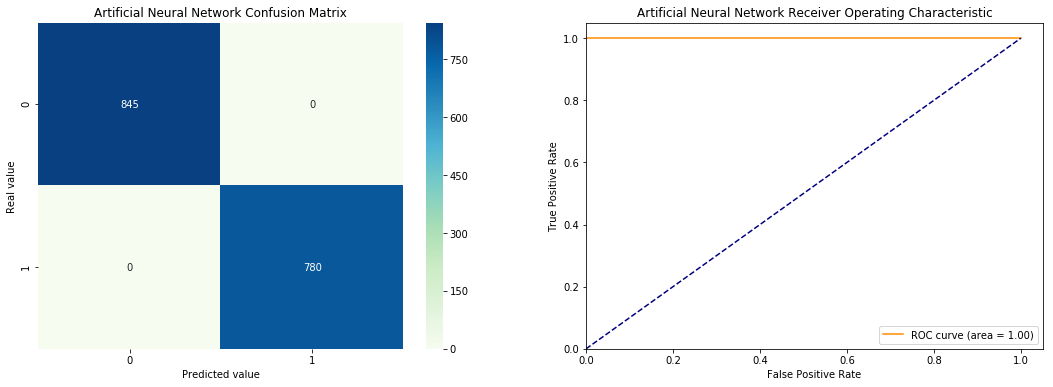

In [45]:
# calculate the fpr and tpr for all thresholds of the classification
ann_roc = ann_fig.add_subplot(1, 2, 2)
fpr, tpr, threshold = metrics.roc_curve(y_test, ann_pred)
roc_auc = metrics.auc(fpr, tpr)

ann_roc=plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)'% roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Artificial Neural Network Receiver Operating Characteristic')
plt.legend(loc="lower right")
display(ann_fig)

In [46]:
ann.get_params()

{'activation': 'relu',
 'alpha': 1e-05,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (5, 2),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_iter': 200,
 'momentum': 0.9,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [47]:
ann.set_params(hidden_layer_sizes=(5, 2),alpha= 0.0001, learning_rate_init= 0.1)
ann.fit(X_train, y_train)
ann_pred=ann.predict(X_test)
print("The accuracy of the Artificial Neural Network on test set is %f" % metrics.accuracy_score(ann_pred,y_test))
print ("The F-measure score of the Artificial Neural Network on test set is %f" % skl.metrics.f1_score(ann_pred,y_test))
#coefs = pd.Series(cls.coef_[0])
fpr, tpr, threshold = metrics.roc_curve(y_test, ann_pred)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)



The accuracy of the Artificial Neural Network on test set is 1.000000
The F-measure score of the Artificial Neural Network on test set is 1.000000
1.0


### 4) Support Vector Machine

In [48]:
#SVM
from sklearn import svm
svc = svm.SVC()
svc.fit(X_train, y_train)
svm_pred=svc.predict(X_test)

cm = metrics.confusion_matrix(y_test, svm_pred)

svm_fig=plt.figure(figsize=(18,6))
svm_cm = svm_fig.add_subplot(1, 2, 1)

svm_cm=sns.heatmap(cm, cmap="GnBu",annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")
plt.title('Support Vector Machine Confusion Matrix')
print("The accuracy of the support vector machine is %f" % metrics.accuracy_score(svm_pred,y_test))
print ("The F-measure score of the support vector machine is %f" % skl.metrics.f1_score(svm_pred,y_test))

svm_results = model_selection.cross_val_score(svc, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %f" % (svm_results.mean()))

The accuracy of the support vector machine is 0.988923
The F-measure score of the support vector machine is 0.988462
10-fold cross validation average accuracy: 0.987691


In [49]:
print('\nTesting Classification Report:')
print(classification_report(y_test, svm_pred))


Testing Classification Report:
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       845
          1       0.99      0.99      0.99       780

avg / total       0.99      0.99      0.99      1625



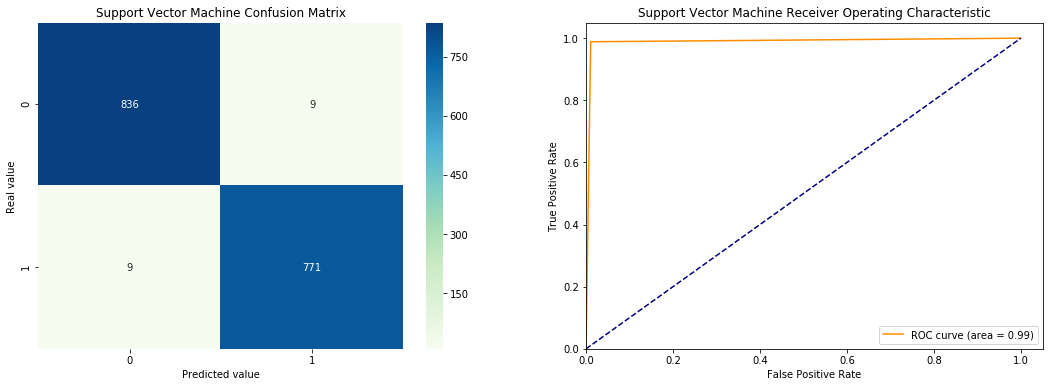

In [50]:
# calculate the fpr and tpr for all thresholds of the classification
svm_roc = svm_fig.add_subplot(1, 2, 2)
fpr, tpr, threshold = metrics.roc_curve(y_test, svm_pred)
roc_auc = metrics.auc(fpr, tpr)

svm_roc=plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)'% roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Support Vector Machine Receiver Operating Characteristic')
plt.legend(loc="lower right")
display(svm_fig)

In [51]:
svc.set_params(C=1.5)
svc.fit(X_train, y_train)
svm_pred=svc.predict(X_test)
print("The accuracy of the Support Vector Machine on test set is %f" % metrics.accuracy_score(svm_pred,y_test))
print ("The F-measure score of the Support Vector Machine on test set is %f" % skl.metrics.f1_score(svm_pred,y_test))
#coefs = pd.Series(cls.coef_[0])
fpr, tpr, threshold = metrics.roc_curve(y_test, svm_pred)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

The accuracy of the Support Vector Machine on test set is 0.990769
The F-measure score of the Support Vector Machine on test set is 0.990403
0.990828402367


### 5) Naive Bayes

In [52]:
# Build model on training data
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB(priors=[0.3,0.7])  
nb.fit(X_train, y_train)  

# prediction scoring of the model (array of binary 0-1)
nb_pred=nb.predict(X_test)
# confusion matrix / missclassification matrix
skl.metrics.confusion_matrix(y_test,nb_pred)
skl.metrics.accuracy_score(y_test, nb_pred)

cm = metrics.confusion_matrix(y_test, nb_pred)

nb_fig=plt.figure(figsize=(18,6))
nb_cm = nb_fig.add_subplot(1, 2, 1)
nb_cm=sns.heatmap(cm, cmap="GnBu",annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")
plt.title('Naive Bayes Confusion Matrix')
print("The accuracy of the Naive Bayes is %f" % metrics.accuracy_score(nb_pred,y_test))
print ("The F-measure score of the Naive Bayes is %f" % skl.metrics.f1_score(nb_pred,y_test))

nb_results = model_selection.cross_val_score(nb, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %f" % (nb_results.mean()))

The accuracy of the Naive Bayes is 0.915692
The F-measure score of the Naive Bayes is 0.908728
10-fold cross validation average accuracy: 0.915524


In [53]:
print('\nTesting Classification Report:')
print(classification_report(y_test, nb_pred))


Testing Classification Report:
             precision    recall  f1-score   support

          0       0.89      0.95      0.92       845
          1       0.95      0.87      0.91       780

avg / total       0.92      0.92      0.92      1625



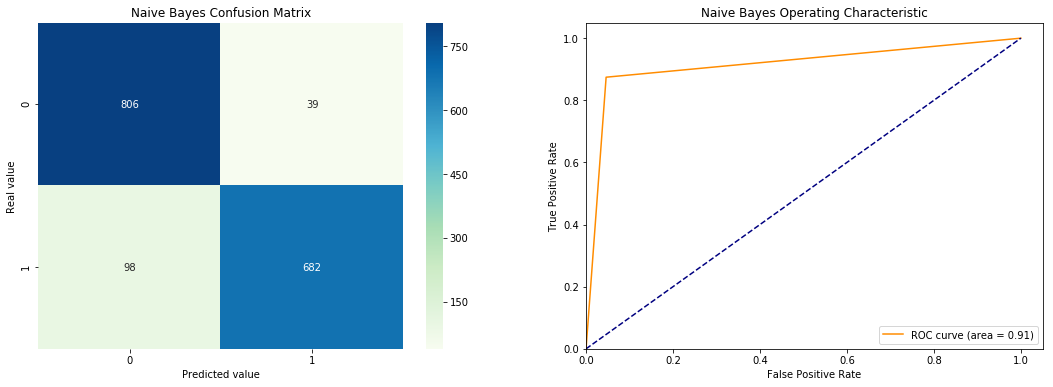

In [54]:
# calculate the fpr and tpr for all thresholds of the classification
knn_roc = nb_fig.add_subplot(1, 2, 2)
fpr, tpr, threshold = metrics.roc_curve(y_test, nb_pred)
roc_auc = metrics.auc(fpr, tpr)

rf_roc=plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)'% roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes Operating Characteristic')
plt.legend(loc="lower right")
display(nb_fig)

In [55]:
nb.get_params()

{'priors': [0.3, 0.7]}

In [56]:
nb.set_params(priors=[0.2,0.8])
nb.fit(X_train, y_train)
nb_pred=nb.predict(X_test)
print("The accuracy of the Naive Bayes on test set is %f" % metrics.accuracy_score(nb_pred,y_test))
print ("The F-measure score of the Naive Bayes on test set is %f" % skl.metrics.f1_score(nb_pred,y_test))
#coefs = pd.Series(cls.coef_[0])
fpr, tpr, threshold = metrics.roc_curve(y_test, nb_pred)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)



The accuracy of the Naive Bayes on test set is 0.883077
The F-measure score of the Naive Bayes on test set is 0.882716
0.884368836292


### Model Evaluation

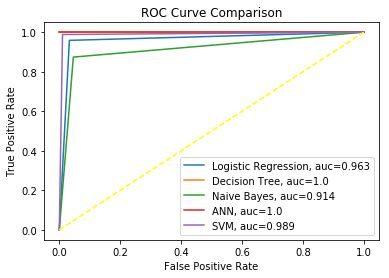

In [66]:
plt.figure(0).clf()

#Logistic Regression
cls = linear_model.LogisticRegression()
cls_result=cls.fit(X_train, y_train)
cls_pred = cls.predict(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, cls_pred)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label="Logistic Regression, auc="+str(round(auc,3)))

# Decision Tree
dt=tree.DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_pred=dt.predict(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, dt_pred)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label="Decision Tree, auc="+str(round(auc,3)))

# Naive Bayes
nb = GaussianNB(priors=[0.3,0.7])  
nb.fit(X_train, y_train)  
nb_pred=nb.predict(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, nb_pred)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label="Naive Bayes, auc="+str(round(auc,3)))
         
#ANN
ann= MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
ann.fit(X_train, y_train)  
ann_pred=ann.predict(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, ann_pred)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label="ANN, auc="+str(round(auc,3)))

#SVM
svc = svm.SVC()
svc.fit(X_train, y_train)
svm_pred=svc.predict(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, svm_pred)
auc = metrics.auc(fpr, tpr) 
plt.plot(fpr,tpr,label="SVM, auc="+str(round(auc,3)))  

plt.plot([0, 1], [0, 1], color='yellow', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc=0)
plt.show(0)